In [1]:
!pip install pykan==0.0.5 -q

In [2]:
from kan import KAN
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
from scipy import stats

In [101]:
df=pd.read_csv('data/creditcard.csv').reset_index()
df=df.iloc[:10000,1:]
df.shape

(10000, 31)

In [102]:
df=df.dropna().sample(frac=1)
df.shape

(10000, 31)

In [103]:
# t-test
selected=[]
for i in range(1,df.shape[1]-1):
    t_stat, p_value = stats.ttest_ind(df[df.Class==0].iloc[:,i], df[df.Class==1].iloc[:,i])
    if p_value<0.01 and abs(t_stat>19):
        selected.append(i)

In [104]:
selected

[3, 7, 10, 12, 14, 16, 17]

In [105]:
#fill whith random numbers
df.V12=np.random.random(df.shape[0])
df.V14=np.random.random(df.shape[0])
df.V17=np.random.random(df.shape[0])

In [106]:
from sklearn.model_selection import train_test_split

select = [12, 14, 17]
dataset = {}
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,select], np.array(df.Class), test_size=0.2, random_state=42, shuffle=True)
dataset['train_input'] = torch.from_numpy(np.array(X_train))
dataset['test_input'] = torch.from_numpy(np.array(X_test))
dataset['train_label'] = torch.from_numpy(np.array(y_train))
dataset['test_label'] = torch.from_numpy(np.array(y_test))


In [107]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
print("Number of samples before over sampling :",X_train.shape)
# oversample
X, y = oversample.fit_resample(dataset['train_input'], dataset['train_label'])
print("Number of samples after over sampling :",X.shape)

dataset['train_input'] = torch.from_numpy(np.array(X))
dataset['train_label'] = torch.from_numpy(np.array(y))


Number of samples before over sampling : (8000, 3)
Number of samples after over sampling : (15930, 3)


In [108]:
model = KAN(width=[3,3], grid=3, k=3) 

In [109]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [110]:
results = model.train(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())


train loss: 1.00e+00 | test loss: 4.41e-01 | reg: 7.78e+01 : 100%|██| 20/20 [00:01<00:00, 14.15it/s]


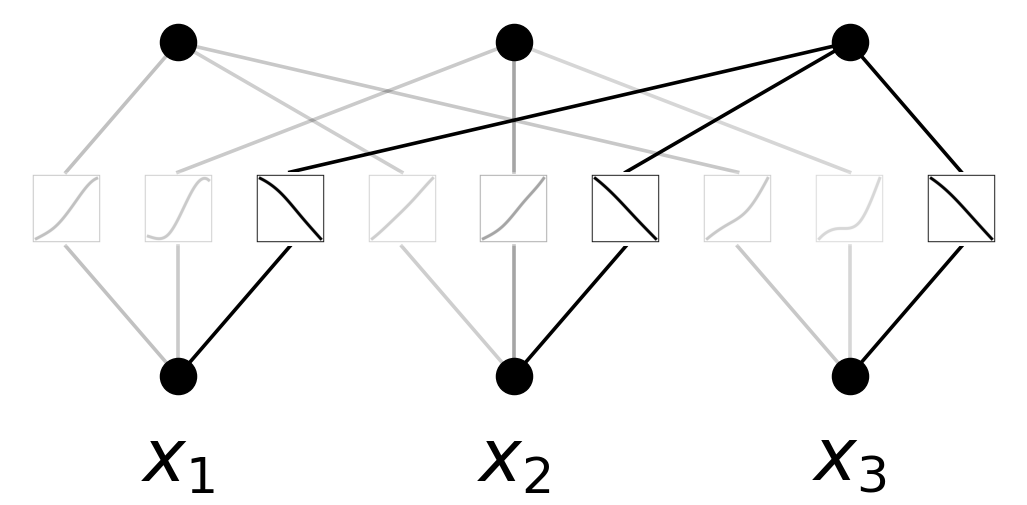

In [111]:
model.plot(beta=0.2,scale=1.3,in_vars=[r'$x_{}$'.format(i) for i in range(1,4)])


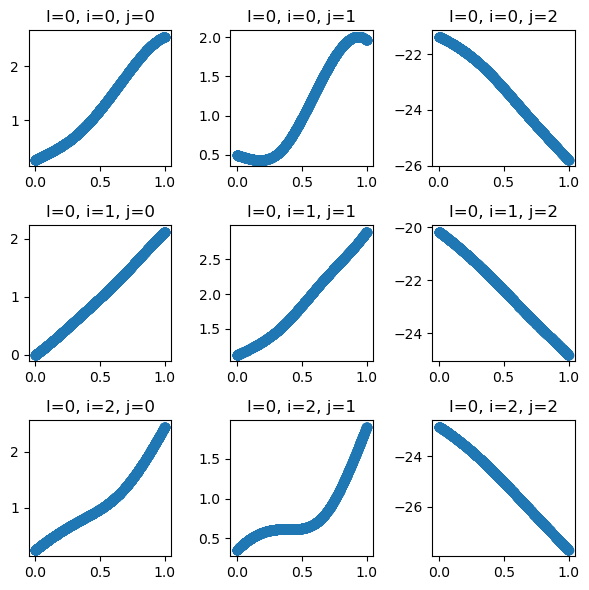

In [112]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
l=0

# Iterate over all combinations of i, j
for i in range(3):
    for j in range(3):
        # Get the appropriate subplot
        inputs = model.spline_preacts[l][:, j, i]
        outputs = model.spline_postacts[l][:, j, i]
        rank = np.argsort(inputs)
        inputs = inputs[rank]
        outputs = outputs[rank]

        # Plot on the appropriate subplot
        ax[i, j].plot(inputs, outputs, marker="o")
        ax[i, j].set_title(f'l={l}, i={i}, j={j}')

# Adjust layout
plt.tight_layout()
plt.show()

In [113]:
model = model.prune()
model(dataset['train_input'])

tensor([[  8.0195,   5.8932, -80.1964],
        [  8.8760,   6.6155, -81.9647],
        [  5.6231,   4.2270, -74.7795],
        ...,
        [  7.3334,   5.4268, -78.7587],
        [  7.6498,   5.9777, -78.8824],
        [  8.3773,   6.3972, -80.7450]], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [114]:
results = model.train(dataset, opt="Adam", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());
results['train_acc'][-1], results['test_acc'][-1]

train loss: 8.57e-01 | test loss: 7.34e-01 | reg: 7.99e+01 : 100%|██| 20/20 [00:01<00:00, 14.69it/s]


(0.5281857848167419, 0.7889999747276306)

In [115]:
(sum(y_test)/len(y_test))*100

0.15

In [116]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X,y)

RandomForestClassifier()

In [117]:
pred = rfc.predict(dataset['test_input'])

In [118]:
import sklearn
rf_f1_score=sklearn.metrics.f1_score(y_test, pred, average='binary')
rf_accuracy_score=sklearn.metrics.accuracy_score(y_test, pred)
print("f1-Score of random forest",rf_f1_score)
print("accuracy of random forest",rf_accuracy_score)

f1-Score of random forest 0.0
accuracy of random forest 0.998


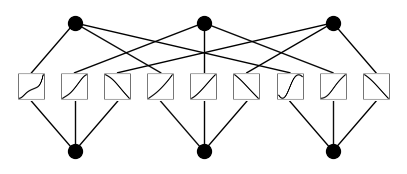

In [119]:
model.plot()


r2 is 0.9462735546571649


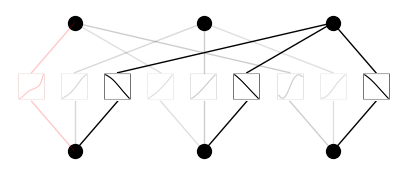

In [120]:
model.fix_symbolic(0,0,0,'sin') # Symbolification
model.plot(beta=0.2)

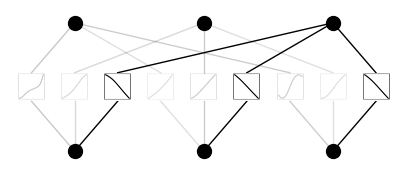

In [121]:
model.unfix_symbolic(0,0,0)
model.plot(beta=0.2)

In [122]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]

fixing (0,0,0) with tan, r2=0.9910908367069287
fixing (0,0,1) with tanh, r2=0.9998016434707856


KeyboardInterrupt: 

In [ ]:
formula1, formula2,formula3 = model.symbolic_formula()[0]
formula1

15.06*sin(0.35*x_3 + 5.23) + 5.09*tan(0.12*x_1 - 8.45) + 31.49*tanh(0.36*x_2 - 0.88) + 41.06

In [ ]:
# how accurate is this formula? subs == substitute value in formula by variable value
def acc(formula1, formula2,formula3, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
        logit3 = np.array(formula3.subs('x_1', X[i,0]).subs('x_2', X[i,1]).subs('x_3', X[i,2])).astype(np.float64)
        correct += (logit3 > logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2,formula3, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2,formula3, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.5000)
test acc of the formula: tensor(0.9955)
